#### **ENCM 509 Final Project**
##### Face Detection and Recognition
##### Authors: Tania Rizwan, Muhammad Haris Kashif

In [ ]:
# Choose 5-10 photos with one or two faces in it.
# • Convert to gray-scale.
# • Perform some pre-processing (such as histogram equalization, smoothing) if needed. This
# depends on the image quality.
# • Performs Face detection:
# – Investigate the original Haar cascades for the frontal face detection, by choosing 2-3 various
# values of the parameters of scalefactor, and minNeighbors. Compare the results, and draw
# conclusions.
# – Investigate the LBP-based Haar cascades for the frontal face detection, by choosing 2-3
# various values of the parameters of scale ratio, step ratio, min size, max size. Compare
# the results, and draw conclusions.
# – Investigate the performance of the HOG+SVM face detection.
# • Evaluate the number of errors in face detection using the above approaches. Draw conclusions.
# • Creation of a Precision vs. Recall graph for each algorithm (with their best performing param-
# eters). Which algorithm is superior in performance?

# RESOURCES FOR CODE 
# https://www.datacamp.com/tutorial/face-detection-python-opencv#face-detection

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure

#### 1. Preprocessing

Size of each image: (112, 92) 10304
Size of each image: (112, 92) 10304


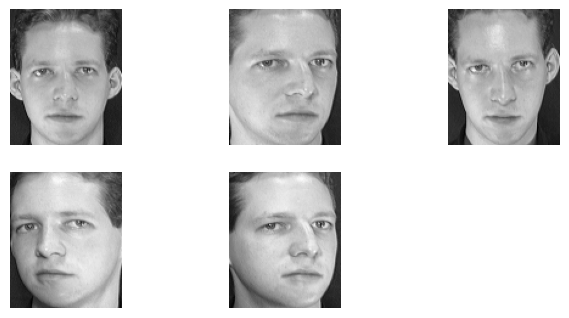

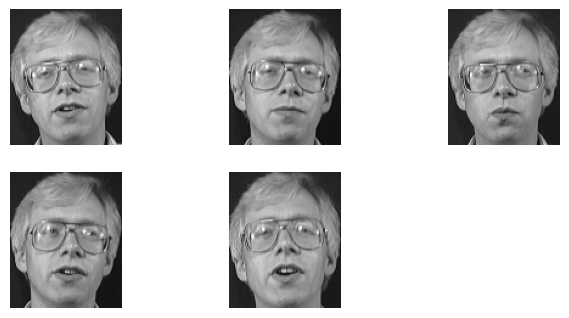

In [32]:
# Choose 5 photos belonging to two faces each

# Specify path for dataset
path = './ATT dataset/'

# Load images for a subject
def load_images(S, subject_dir, M):
    """
    Load images from the ATT dataset and place them in an array

    Parameters:
    S - empty matrix of size (rows x cols) x M to store images
    subject_dir - directory for subject to load images from
    M - number of images to load

    Returns:
    S - matrix filled with images from dataset
    """


    plt.figure(figsize=(8,6))
    for i in range(1,M+1):
        img = imread(path + f'{subject_dir}/' + '{}.pgm'.format(i), as_gray=True)
        irow, icol = img.shape

        plt.subplot(3,3,i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # reshape(img',irow*icol,1);
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,i-1] = temp[:,0]
    # after finishing the sequence, S is a N1*N2xM matrix

    print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))
    return S


# Setup to load images for Subject 1
M = 5 # Num of photos to load

img1 = imread(path + 's1/' + '1.pgm', as_gray=True) # Get dimensions of one image

irow1, icol1 = img1.shape # Get the number of rows (irow) and columns (icol). These values must to be the same for all images

S1 = np.zeros((irow1*icol1, M)) # Allocation of matrix that will have all images

S1 = load_images(S=S1, subject_dir='s1', M = 5)


# Setup to load images for Subject 2
img2 = imread(path + 's2/' + '1.pgm', as_gray=True) # Get dimensions of one image

irow2, icol2 = img2.shape # Get the number of rows (irow) and columns (icol). These values must to be the same for all images

S2 = np.zeros((irow2*icol2, M)) # Allocation of matrix that will have all images

S2 = load_images(S=S2, subject_dir='s2', M = 5)



Normalized Dataset


/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_19427/2600785477.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/hj/s9v7ssj93qg4kmnzqv9mm2740000gn/T/ipykernel_19427/2600785477.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


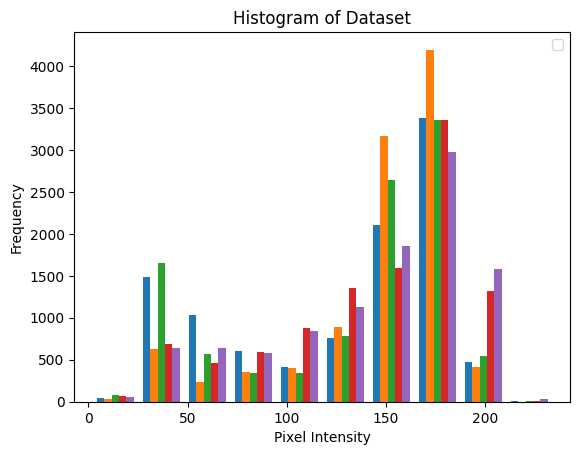

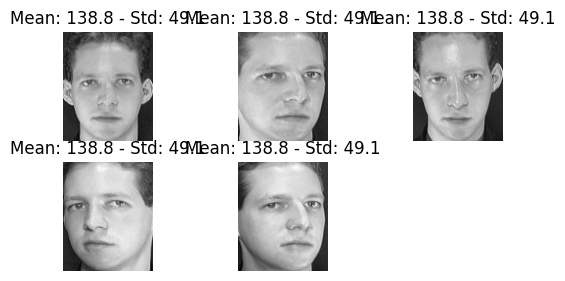

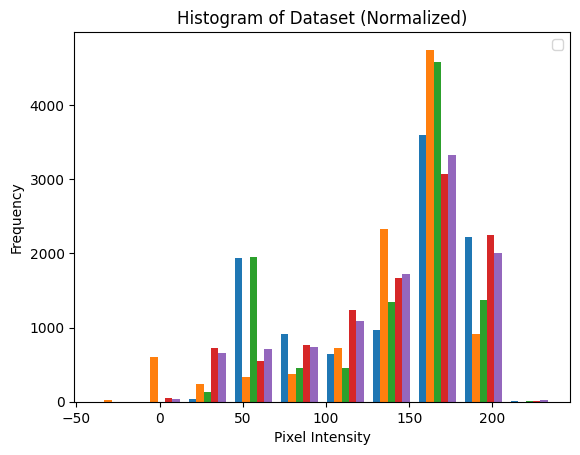

In [ ]:
# Normalize images 

def image_normalizer(S, M, irow, icol):
    """
    Normalize each image in a provided dataset, where the dataset is a matrix of images

    Parameters:
    S - matrix filled with images from dataset
    M - number of images in dataset
    irow, icol - dimensions of images in dataset (should be same for all images)

    Returns:
    S - normalized matrix of images from dataset
    """

    #1. Plot histogram of dataset 
    plt.figure()
    plt.hist(S, bins = 10, density = False)
    plt.title("Histogram of Dataset")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    # 2. Determine global mean and std
    mu = np.mean(S)
    std = np.std(S)

    # Loop over all loaded images in dataset
    for i in range(S.shape[1]):
        temp = S[:, i] # Load image i
        m = np.mean(temp) # Mean of image
        st = np.std(temp) # Std of image
        # Determine new pixel intensities
        S[:,i] = (temp - m) * std / st + mu # Modify original dataset matrix
    
    # Plot normalized dataset
    print("\nNormalized Dataset")
    plt.figure()
    for i in range(M):
        img = np.reshape(S[:,i], (irow, icol))

        plt.subplot(3, 3,i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

    # Plot updated histogram
    plt.figure()
    plt.hist(S, bins = 10, density = False)
    plt.title("Histogram of Dataset (Normalized)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()

    return S

# Normalize Images for S1
S1_norm = image_normalizer(S = S1, M = M, irow = irow1, icol = icol1)
S2_norm = image_normalizer(S = S2, M = M, irow = irow2, icol = icol2)


In [ ]:
def image_equalizer()